### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 100  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.00032892188007938847
Discretized Result: 0.0003289218016943769


### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


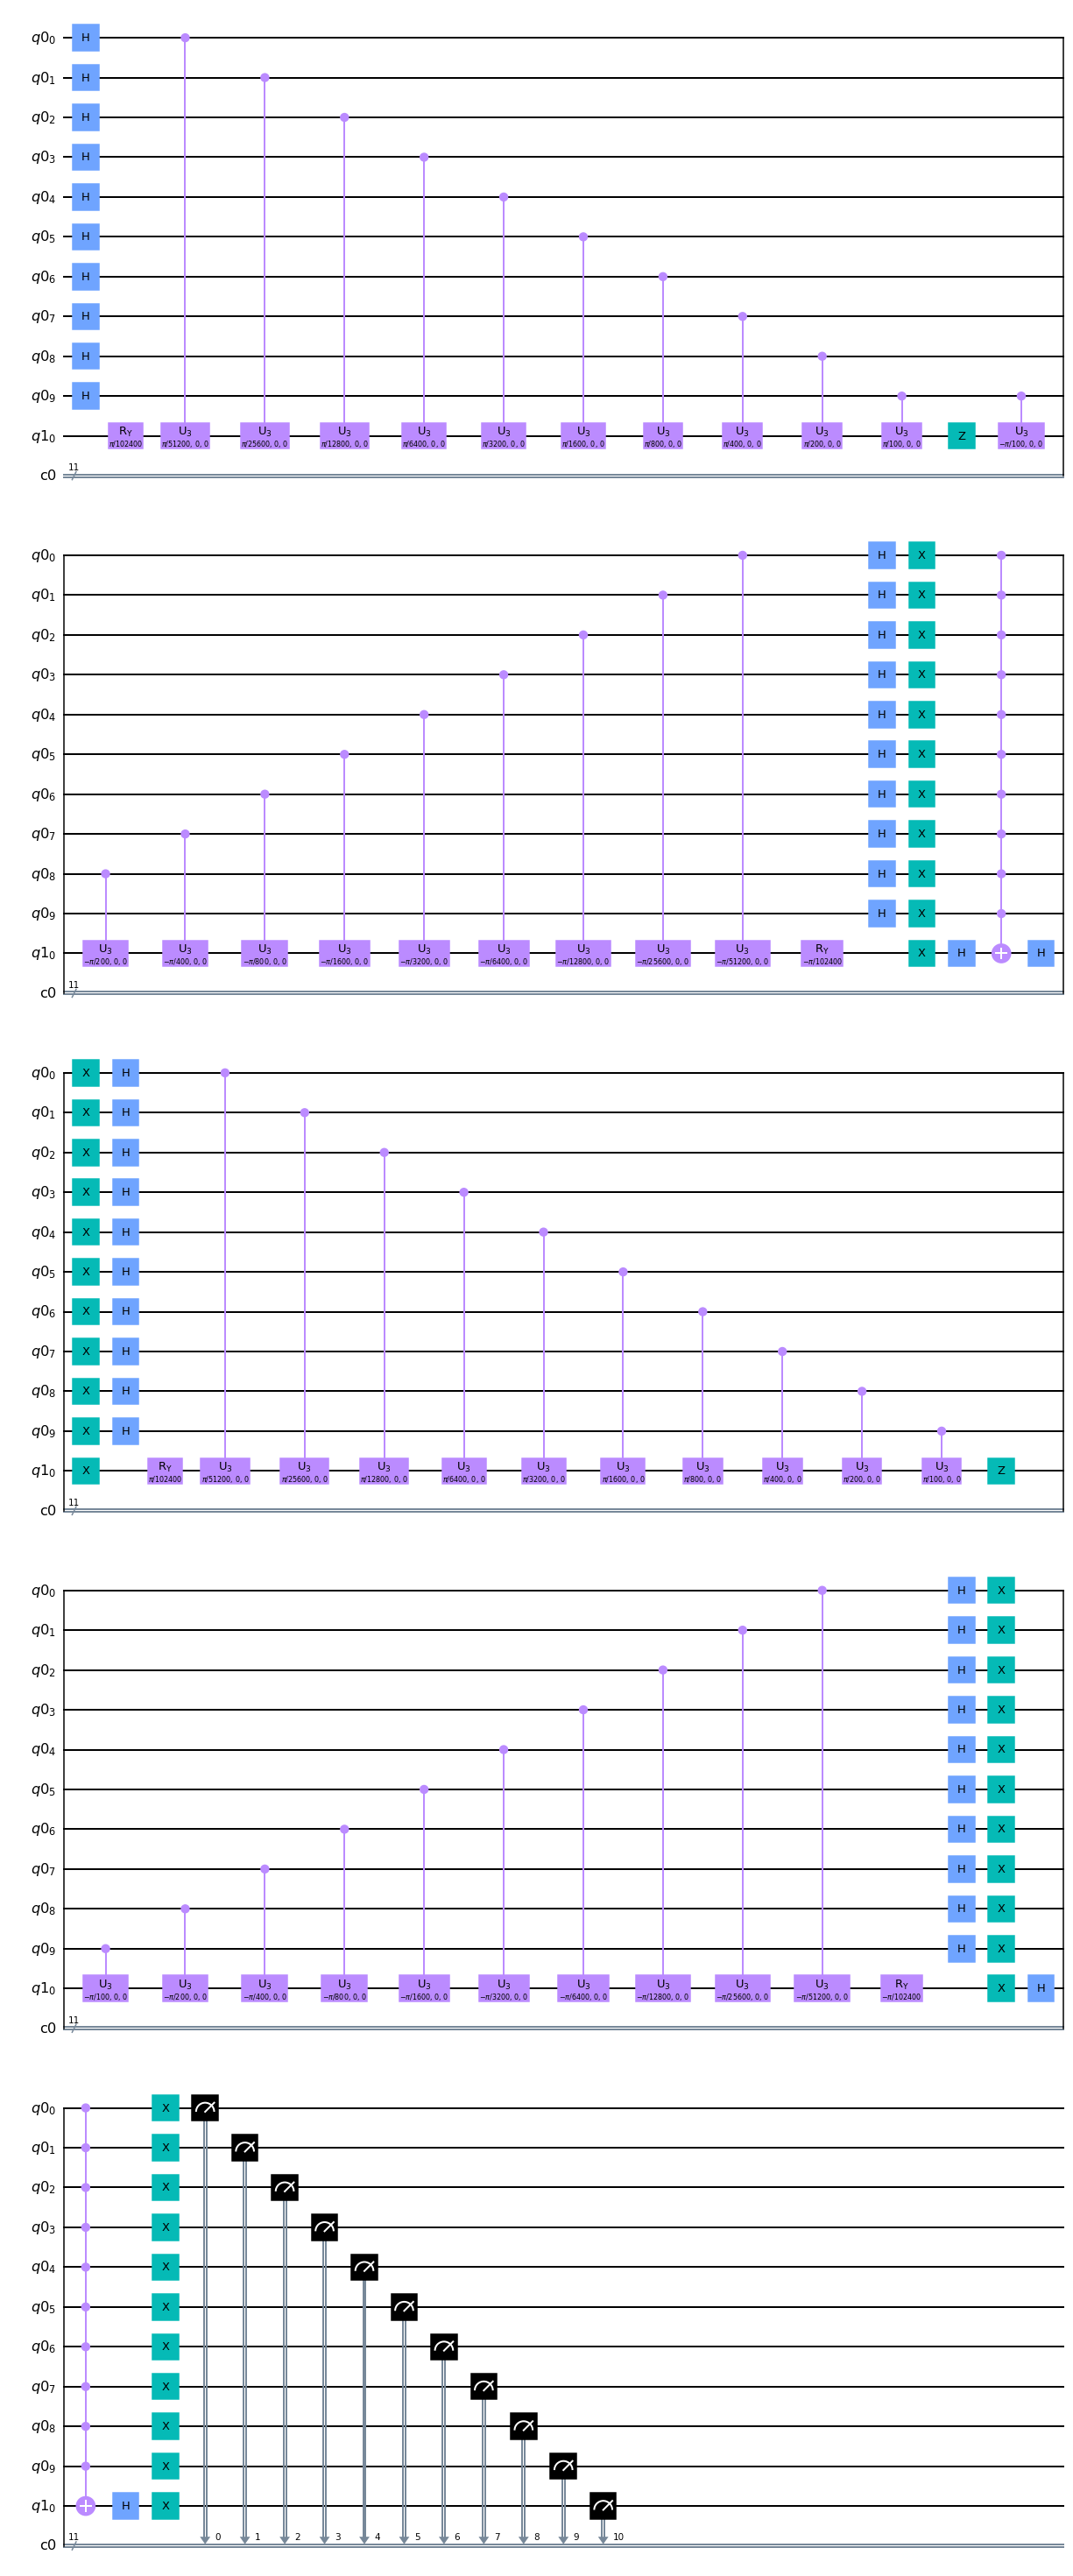

In [5]:
qc_list = create_grover_circuit([2], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.95, 0.05],[0.05,0.95]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [14]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.9714212417602539 s
1 th round with 1 oracles
0.016704082489013672 s
2 th round with 2 oracles
0.0236361026763916 s
3 th round with 3 oracles
0.030968666076660156 s
4 th round with 4 oracles
0.0399479866027832 s
5 th round with 5 oracles
0.04762601852416992 s
6 th round with 6 oracles
0.05465221405029297 s
7 th round with 7 oracles
0.06707382202148438 s
8 th round with 8 oracles
0.07009530067443848 s
9 th round with 9 oracles
0.07658982276916504 s
10 th round with 10 oracles
0.09518313407897949 s
11 th round with 11 oracles
0.0890350341796875 s
12 th round with 12 oracles
0.08904695510864258 s
13 th round with 13 oracles
0.10445833206176758 s
14 th round with 14 oracles
0.09665203094482422 s
15 th round with 15 oracles
0.12907004356384277 s
16 th round with 16 oracles
0.1215670108795166 s
17 th round with 17 oracles
0.12773394584655762 s
18 th round with 18 oracles
0.13335704803466797 s
19 th round with 19 oracles
0.14854001998901367 s
20 th round with 20 ora

In [15]:
import pickle
with open("raw_result_10_005_005.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_10_005_005.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[58, 54, 61, 49, 61, 55, 57, 52, 51, 49, 44, 47, 42, 46, 46, 36, 34, 39, 39, 32, 31, 28, 29, 22, 35, 26, 26, 24, 18, 16, 16, 12, 13, 4, 10, 7, 5, 7, 6, 3, 1, 4, 4, 4, 5, 2, 2, 5, 1, 8, 3, 5, 5, 8, 9, 8, 13, 8, 21, 19, 11, 24, 22, 28, 26, 34, 26, 41, 38, 32, 44, 37, 39, 47, 43, 49, 43, 53, 49, 57, 53, 54, 51, 51, 53, 59, 55, 66, 56, 61, 51, 56, 49, 48, 55, 53, 54, 49, 42, 42]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000027
number of positive values:  1022
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999992
number of positive values:  1020
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000007
number of positive values:  1026
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999969
number of positive values:  1009
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000007
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999979
number of positive values:  1030
main process: Done!
strict

sum of mitigated probability vector x: 1.0000000000000018
number of positive values:  1022
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1020
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999988
number of positive values:  1021
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999982
number of positive values:  1023
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999987
number of positive values:  1017
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999998
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of

In [12]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2194592891964415
sum of mitigated probability vector x_hat_s: 1.2195310794721899
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.185927093065178
sum of mitigated probability vector x_hat_s: 1.1860092936477629
number of positive values:  19
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2427387680805773
sum of mitigated probability vector x_hat_s: 1.2428004855440886
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2166522012689258
sum of mitigated probability vector x_hat_s: 1.2167224382388762
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Mul

sum of mitigated probability vector x_s: 1.2226522315217476
sum of mitigated probability vector x_hat_s: 1.222498764451715
number of positive values:  28
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1935560642212182
sum of mitigated probability vector x_hat_s: 1.1934175285485147
number of positive values:  28
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2928711182804518
sum of mitigated probability vector x_hat_s: 1.292738442293955
number of positive values:  26
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2592284418427069
sum of mitigated probability vector x_hat_s: 1.2591205557700593
number of positive values:  22
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

sum of mitigated probability vector x_s: 1.2135103799729487
sum of mitigated probability vector x_hat_s: 1.213555762013316
number of positive values:  21
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2097779249122849
sum of mitigated probability vector x_hat_s: 1.2098479688752806
number of positive values:  17
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2510578074172167
sum of mitigated probability vector x_hat_s: 1.2511263309411127
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.2349966970972694
sum of mitigated probability vector x_hat_s: 1.235072634361543
number of positive values:  21
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

In [13]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney_list)

The heuristcs by Mooney et al. + SGS algorithm
{384: 0.017145385325538148, 528: 0.016072312812285855, 48: 0.0161336568120015, 8: -0.022191353663223282, 65: 0.014276667555835327, 40: 0.01714885681127414, 512: -0.020047947416107745, 32: -0.020062953238884088, 128: -0.0370619055971339, 1184: 0.01804339985926387, 1088: 0.03434763774914251, 144: 0.017041202728657303, 0: 1.0224932840359007, 1040: 0.016100908167811786, 648: 0.018022481986444797, 4: 0.03459813587268775, 26: 0.018031907275335202, 1: 0.05837076105619529, 2: 0.0190096362382101, 1024: -0.023151209629253613}
sum of counts: 1.2143208647419814
number of positive values:  15
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{512: -0.03389272800142614, 9: 0.015847149734762284, 564: 0.017964875093965327, 16: 0.038594339830834795, 580: 0.018064335315668, 64: 0.07481995457355253, 1: 0.02540911311579885, 12: 0.017994749784385203, 128: 0.020953994801253262, 544: 0.017116959052942426, 324: 0.018122441516286756, 1024: -0.0150

{528: 0.012531379051557719, 32: 0.01692089933929005, 1568: 0.015504302652118333, 1544: 0.01598294750705369, 256: 0.018371828304959134, 1088: 0.024224772818125923, 1026: 0.026118899448687803, 1410: 0.017236600092105436, 144: 0.016156411073476217, 2: -0.01924901737002025, 1600: 0.015013909179289943, 544: 0.013453622463383766, 128: -0.018590145963954512, 1536: 0.018427275344607218, 8: 0.033294211194266364, 1068: 0.017018216775527166, 1: 0.021040061514340763, 1408: 0.017082743504861872, 16: 0.01416732432033479, 1024: 0.16928389913017106, 1064: 0.01708285460375759, 512: 0.014387909735889111, 1040: 0.021981756490671602, 1664: 0.016402893526677308, 0: 0.6722288770163511, 584: 0.0180526324443303, 1552: 0.031952697993942215}
sum of counts: 1.2360797621918016
number of positive values:  25
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1029: 0.01722841990090479, 1312: 0.0152325427019034, 32: 0.024111910593760093, 512: -0.017447891452310585, 1536: 0.06737544888538165, 1152: 0

In [22]:
import pickle
with open("hit_list_10_005_005.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [14]:
import pickle
with open("mit_hit_list_10_005_005.pkl", "wb")as f:
    pickle.dump(mit_hit_list, f)

In [23]:
"""
import pickle
with open("mit_hit_S_list_10_005_005.pkl", "wb")as f:
    pickle.dump(mit_hit_S_list, f)
"""

In [15]:
import pickle
with open("mit_hit_S_lm_0_list_10_005_005.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [16]:
import pickle
with open("mit_hit_mooney100_list_10_005_005.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [17]:
with open("hit_list_10_005_005.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_list_10_005_005.pkl", "rb") as f:
    mit_hit_list = pickle.load(f)
with open("mit_hit_S_list_10_005_005.pkl", "rb") as f:
    mit_hit_S_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_10_005_005.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
    with open("mit_hit_mooney100_list_10_005_005.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

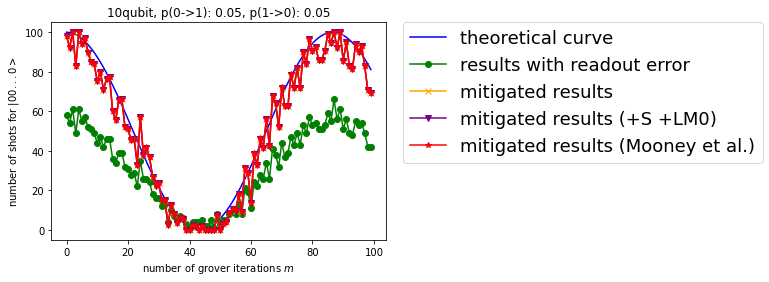

In [17]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("10qubit, p(0->1): 0.05, p(1->0): 0.05")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [18]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_list = [100 - h for h in mit_hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney_list = [100 - h for h in mit_hit_mooney_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_list = calculate_theta(
    sin_mit_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney_list = calculate_theta(
    sin_mit_hit_mooney_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_list = np.abs(np.sin(thetaCandidate_mit_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney_list = np.abs(np.sin(thetaCandidate_mit_mooney_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

../libmitigation/lib_grover.py:224: RuntimeWarning: invalid value encountered in sqrt
  theta = np.arcsin(np.sqrt(p))  # search theta


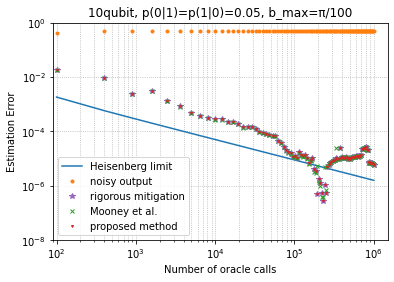

In [19]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
p2 = plt.loglog( OracleCall_list, error_mit_mooney_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.05, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "Mooney et al.", "proposed method"))
plt.show()